In [1]:
# Basic building-block packages
import numpy as np
from numpy import heaviside as th

# For numerical solutions of ODEs
from scipy.integrate import solve_ivp

# Some fancy-smancy maths!! (not really)
from scipy.stats import linregress
from numpy.linalg import norm

# For pretty-pretty graphs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

# Quality of life shit
from tqdm import tqdm
import pickle

import scipy.fftpack as fft



def NIC(x,a,b,B):
    g = -a*x*(th(x+B,1)-th(x-B,1)) # Centre
    g += (b*x+(a+b)*B)*th(-x-B,1) # Lefterior
    g += (b*x-(a+b)*B)*th(x-B,1) # Righterior
    return g

def Chua(x,a1,b1,B1,a2,b2,B2):
    return NIC(x,a1,b1,B1)+NIC(x,a2,b2,B2)

def sys_DE(t,w,inte,exte,circ):
    """
    Defines Chua's equations

    Arguments:
        w :  vector of the state variables:
                  w = [x,y,z]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x,y,z = w
    R,C1,C2,L,F,freq = circ
    dx = ((y-x)/R-Chua(x,*inte,*exte))/C1
    dy = ((x-y)/R+z)/C2
    dz = -y/L-(F*np.sin(2*np.pi*freq*t))/L
    return dx,dy,dz

## Simulated Lorenz System

### Second method of bifurcation diagram

"Use final values of the nth run as the initial values of the (n+1)th run to 'stay near the attractor.'"

https://stackoverflow.com/questions/62842261/in-python-how-to-make-a-bifurcation-diagram-of-the-lorenz-system-under-a-varyin

Also, for the lyapunov exponents, I refer yall to this source: 

https://cmp.phys.ufl.edu/PHZ4710/files/unit5/Lorenz-system.html

We basically want to perturb the system *after* it has settled. 

100%|██████████| 200/200 [00:08<00:00, 23.08it/s]


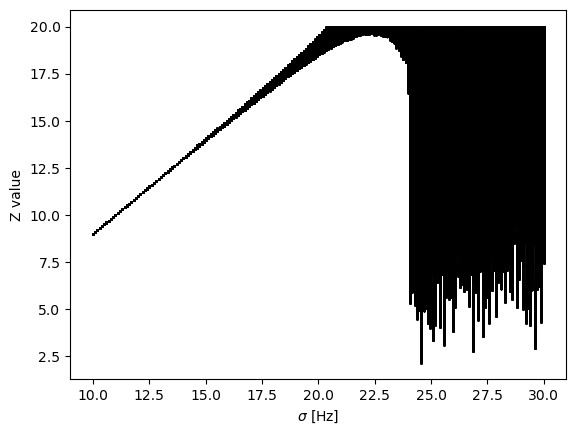

In [4]:
def lor_sys(t,w,sigma,rho,beta):
    """
    Defines Chua's equations

    Arguments:
        w :  vector of the state variables:
                  w = [x,y,z]
        t :  time
    """
    x,y,z = w
    dx = sigma*(y-x)
    dy = x*(rho-z)-y
    dz = x*y-beta*z
    return dx,dy,dz

t_span = (0,50)
t_eval = np.linspace(*t_span,int(1e5)) # No need to be so fine like here. 
xyz0 = [2,1,1] # Recall that z is in Amperes (a large unit).

sigma = np.linspace(10,30,200)

for s in tqdm(sigma): 
    solution = solve_ivp(lor_sys,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                        args=[10,s,8/3])
    z_sol = solution.y[2][solution.t>20] # ignore all transient states
    # z_sol = solution.y[2]
    eps = 1e-8

# Remove for loop and optimise caclulation. 
    # Make boolean array for closeness to 2.
    msk = np.abs(z_sol-eps) < 20

    # Make boolean mask for direction vector
    delta = np.diff(z_sol)
    delta = np.append(delta,0)
    delta = delta < 0

    indices = np.where(msk& delta)[0] # Merge booleans and find index

    plt.scatter(np.full(len(indices),s), z_sol[indices]
                ,color="k",s=0.1)
            
plt.ylabel("Z value"); plt.xlabel(r"$\sigma$ [Hz]")
plt.show()
plt.close("all")

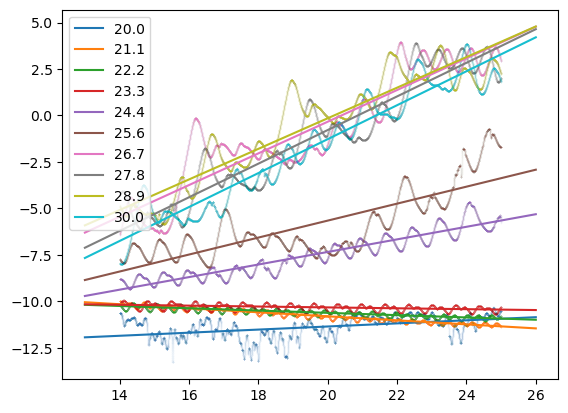

In [27]:
X1_0 = np.array([2.0,1.00,1]) 
X2_0 = X1_0+np.array([0,.0001,0])

t_span = (0,50)
t_eval = np.linspace(*t_span,int(1e5)) # No need to be so fine like here. 

lyau = []
for rho in tqdm(np.linspace(20,30,10),leave=False):
    
    sol1 = solve_ivp(lor_sys,t_span,X1_0
                    ,args=[10,rho,8/3]
                    ,t_eval=t_eval
                    )
    sol2 = solve_ivp(lor_sys,t_span,X2_0
                    ,args=[10,rho,8/3]
                    ,t_eval=t_eval
                    )
    # Assume transience is gone after t>trn and saturation at t>sat.
    trn = 14; sat = 25
    dX = norm(sol1.y-sol2.y,axis=0)
    y = np.log(dX[(trn<sol1.t) & (sol1.t<sat)])

    t = sol1.t[(trn<sol1.t) & (sol1.t<sat)]

    fit = linregress(t,y)
    m = fit.slope
    b = fit.intercept
    corr = fit.rvalue**2
    
    lyau.append(y)

    plt.scatter(t,y,s=0.1,alpha=0.03)
    X = np.array([min(t)-1,max(t)+1])
    plt.plot(X,m*X+b,label=f"{round(rho,ndigits=1)}")

plt.legend(loc="upper left")

## Fast Fourier Transform

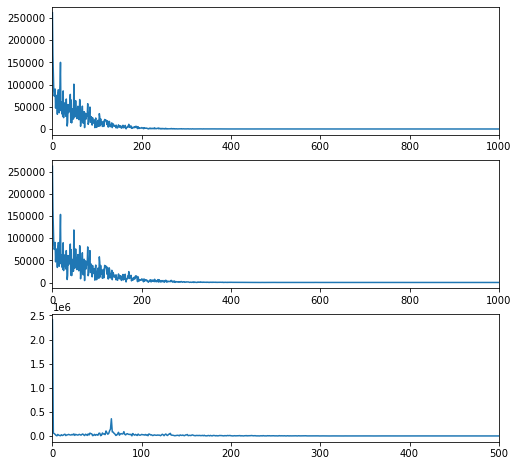

In [3]:
# sample spacing

Xf = fft.fft(x_sol)
Yf = fft.fft(y_sol)
Zf = fft.fft(z_sol)

samp = 1e5
tau = 1/samp # time interval

freq = fft.fftfreq(len(x_sol), tau)

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(3,1,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[1,0])
axs3 = plt.subplot(grid[2,0])

axs1.set_xlim(left=0, right=1000, emit=True, auto=False)
axs2.set_xlim(left=0, right=1000, emit=True, auto=False)
axs3.set_xlim(left=0, right=500, emit=True, auto=False)

axs1.plot(freq[freq>=0], np.abs(Xf)[freq>=0])
axs2.plot(freq[freq>=0], np.abs(Yf)[freq>=0])
axs3.plot(freq[freq>=0], np.abs(Zf)[freq>=0])

plt.show()

## Finding Appropreate Frequency (Phase+FFT+Poincare)

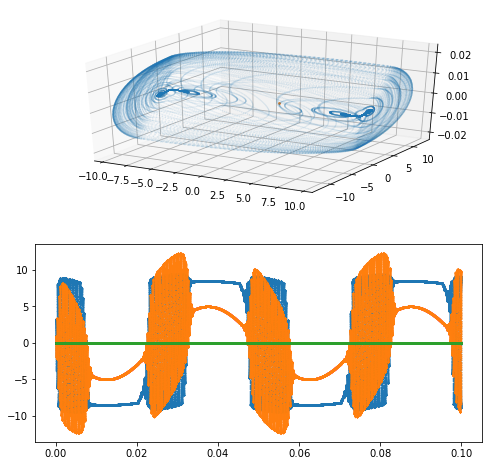

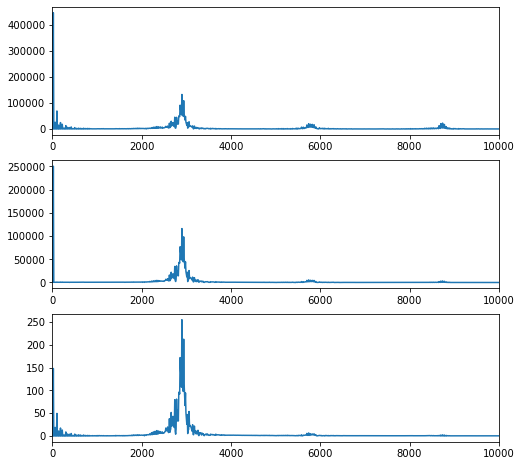

Draw plots: 100%|██████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 260434.90it/s]


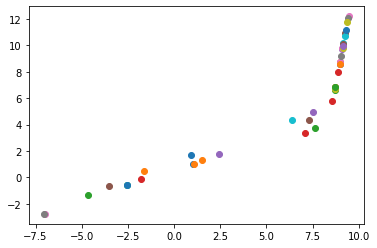

In [3]:
# Numerical integration by solve_ivp

R = 1410
C1 = 10e-9
C2 = 100e-9
L = 25e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

F = 5

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

freq = 20

circ = [R,C1,C2,L,F,freq]

t_span = (0,.10)
t_eval = np.linspace(*t_span,int(1e7)) # No need to be so fine like here. 
xyz0 = [1,1,0] # Recall that z is in Amperes (a large unit).
solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                    args=[interior,exterior,circ])

x_sol = solution.y[0]; y_sol = solution.y[1]; z_sol = solution.y[2]
time = solution.t

frc = 0; div = 100
x_sol = x_sol[frc::div]
y_sol = y_sol[frc::div]
z_sol = z_sol[frc::div]
time = time[frc::div]

# Plot the solutions
fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,1,wspace=0.1,)

axs1 = fig.add_subplot(grid[0], projection='3d')
axs2 = plt.subplot(grid[1])

axs1.scatter(x_sol,y_sol,z_sol
            ,s=0.003
            )
axs1.scatter(x_sol[0],y_sol[0],z_sol[0]
            ,s=3
            )
# axs1.invert_xaxis()
# axs1.invert_yaxis()

for var in [x_sol,y_sol,z_sol]:
    axs2.scatter(time, var,s=0.3)

plt.show()

Xf = fft.fft(x_sol)
Yf = fft.fft(y_sol)
Zf = fft.fft(z_sol)

eps = 5e-5
tau = 1e-6 # time interval

freq = fft.fftfreq(len(x_sol), tau)

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(3,1,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[1,0])
axs3 = plt.subplot(grid[2,0])

axs1.set_xlim(left=0, right=10000, emit=True, auto=False)
axs2.set_xlim(left=0, right=10000, emit=True, auto=False)
axs3.set_xlim(left=0, right=10000, emit=True, auto=False)

axs1.plot(freq[freq>=0], np.abs(Xf)[freq>=0])
axs2.plot(freq[freq>=0], np.abs(Yf)[freq>=0])
axs3.plot(freq[freq>=0], np.abs(Zf)[freq>=0])

plt.show()

for i in tqdm(range(len(z_sol)),desc="Draw plots"):
    if -eps<z_sol[i]<eps:
        if (z_sol[i+1]-z_sol[i])/(2*tau)<0:
            plt.scatter(x_sol[i], y_sol[i])
                
plt.show()

## Bifurcation Map

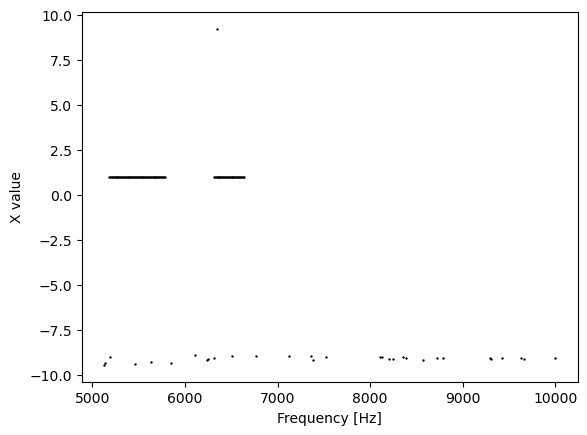

In [5]:
# Numerical integration by solve_ivp

R = 1410
C1 = 10e-9
C2 = 100e-9
L = 25e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

F = 5

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

Freq = np.linspace(5000, 10000, 500)

for freq in tqdm(Freq,leave=False,position=0):
    
    circ = [R,C1,C2,L,F,freq]

    t_span = (0,0.10)
    t_eval = np.linspace(*t_span,int(1e4)) # No need to be so fine like here. 
    xyz0 = [1,1,0] # Recall that z is in Amperes (a large unit).
    solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                        args=[interior,exterior,circ])

    x_sol = solution.y[0]; y_sol = solution.y[1]; z_sol = solution.y[2]
    time = solution.t

    frc = 0; div = 100
    x_sol = x_sol[frc::div]
    y_sol = y_sol[frc::div]
    z_sol = z_sol[frc::div]
    time = time[frc::div]

    eps = 5e-5
    tau = 1e-6

# Remove for loop and optimise caclulation. 
    # Make boolean array for closeness to 0.
    msk = np.abs(z_sol) < eps

    # Make boolean mask for direction vector
    delta = np.diff(z_sol)
    delta = np.append(delta,0)
    delta = delta < 0

    indices = np.where(msk& delta)[0] # Merge booleans and find index

    plt.scatter(np.full(len(indices),freq), x_sol[indices]
                ,color="k",s=0.5)
            
plt.ylabel("X value"); plt.xlabel("Frequency [Hz]")
plt.show()
plt.close("all")

### Lyapunov exponent for chua's system

In [6]:
X1_0 = np.array([2.0,1.00,1]) 
X2_0 = X1_0+np.array([0,.0001,0])

t_span = (0,2)
t_eval = np.linspace(*t_span,int(1e5)) # No need to be so fine like here. 

R = 1410
C1 = 10e-9
C2 = 100e-9
L = 25e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

F = 5
Freq = np.linspace(10, 300, 100)

for freq in tqdm(Freq,leave=False,position=0):
    circ = [R,C1,C2,L,F,freq]
    
    sol1 = solve_ivp(sys_DE,t_span,X1_0
                    ,args=[interior,exterior,circ]
                    ,t_eval=t_eval
                    )
    sol2 = solve_ivp(sys_DE,t_span,X2_0
                    ,args=[interior,exterior,circ]
                    ,t_eval=t_eval
                    )
    # Assume transience is gone after t>trn and saturation at t>sat.
    trn = 1e-5; sat = 100
    dX = norm(sol1.y-sol2.y,axis=0)
    y = np.log(dX[(trn<sol1.t) & (sol1.t<sat)])

    t = sol1.t[(trn<sol1.t) & (sol1.t<sat)]

    fit = linregress(t,y)
    m = fit.slope
    b = fit.intercept
    # corr = fit.rvalue**2

    plt.scatter(t,y,s=0.1,alpha=0.03)
    X = np.array([min(t)-1,max(t)+1])
    plt.plot(X,m*X+b,label=f"{round(freq,ndigits=1)}")

plt.legend(loc="upper left")

  1%|          | 1/100 [01:32<2:32:56, 92.70s/it]

: 